# Change runtime type to R

Remember, the first step when opening a Google Colab notebook is to change the runtime type to R from Python. Our code will not work otherwise!

# Load the packages and the dataset

We return to the mtcars dataset in base R.

Here, our focal variables are as follows:

1) Transmission (am): The type of transmission of the cars. 1 is manual, 0 is automatic. In logistic
regression, we don’t strictly need to treat the binary DV as a factor, although we could.

2) Weight (wt): The weight, in 1,000 pound increments, of the 32 cars.

3) Miles per gallon (mpg): The fuel economy of the cars.


In [2]:
## Install packages for Google Colab
install.packages("easystats")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘patchwork’, ‘bayestestR’, ‘correlation’, ‘datawizard’, ‘effectsize’, ‘insight’, ‘modelbased’, ‘parameters’, ‘performance’, ‘report’, ‘see’




In [14]:
## Load in the packages
library(tidyverse) ## Several useful functions
library(easystats) ## Several useful functions

## Load in the data
data(mtcars)

## Subset the data to the columns of interest
NewCar <-
  mtcars %>%
  select(am, wt, mpg)

## Look at the dataset
NewCar %>% head(n = 10)

,am,wt,mpg
,<dbl>,<dbl>,<dbl>
Mazda RX4,1,2.620,21.0
Mazda RX4 Wag,1,2.875,21.0
Datsun 710,1,2.320,22.8
Hornet 4 Drive,0,3.215,21.4
Hornet Sportabout,0,3.440,18.7
Valiant,0,3.460,18.1
Duster 360,0,3.570,14.3
Merc 240D,0,3.190,24.4
Merc 230,0,3.150,22.8


## Descriptive and summary statistics

Note: Because `am` (i.e., transmission) is a binary variable, we should technically use other forms of a correlation. Specifically, we should use a point biserial correlation coefficient but we did not learn that in this
class.

In general, for regression, we want to show the correlation values. Too large of a correlation is actually a bad thing in regression. Let’s pretend we don’t have collinearity issues.

In [4]:
## Return the descriptive statistics for the variables
describe_distribution(NewCar)

Variable,Mean,SD,IQR,Min,Max,Skewness,Kurtosis,n,n_Missing
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
am,0.40625,0.4989909,1.00000,0.000,1.000,0.4008089,-1.96655033,32,0
wt,3.21725,0.9784574,1.18625,1.513,5.424,0.4659161,0.41659467,32,0
mpg,20.09062,6.0269481,7.52500,10.400,33.900,0.6723771,-0.02200629,32,0


In [5]:
## Describe the am variable
NewCar$am %>%
  table()

.
 0  1 
19 13 

In [12]:
## Same information as above in percent form
NewCar$am %>%
  table() %>%
  prop.table() * 100

.
     0      1 
59.375 40.625 

In [36]:
## Return the correlations among the variables to check for collinearity
CorData <-
  correlation(data = NewCar)

## Displaying the object produces an error, forcing it as a data frame fixes that
CorData %>%
  as.data.frame() ## Force into data.frame type object to fix weird bug

,Parameter1,Parameter2,r,CI,CI_low,CI_high,t,df_error,p,Method,n_Obs
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<int>
1,am,wt,-0.6924953,0.95,-0.8386752,-0.4532461,-5.257603,30,2.250879e-05,Pearson correlation,32
2,am,mpg,0.5998324,0.95,0.3175583,0.7844520,4.106127,30,2.850207e-04,Pearson correlation,32
3,wt,mpg,-0.8676594,0.95,-0.9338264,-0.7440872,-9.559044,30,3.881876e-10,Pearson correlation,32


# Visualization

We have a binary outcome variable so we are using logistic regression here. That means if we are finding the line-of-best-fit, it will actually look like a curve.

**Predicting transmission type from weight**

There is a negative trend here. The larger the weight of the variable, the less likely we are to have a manual transmission car (`am` = 1).

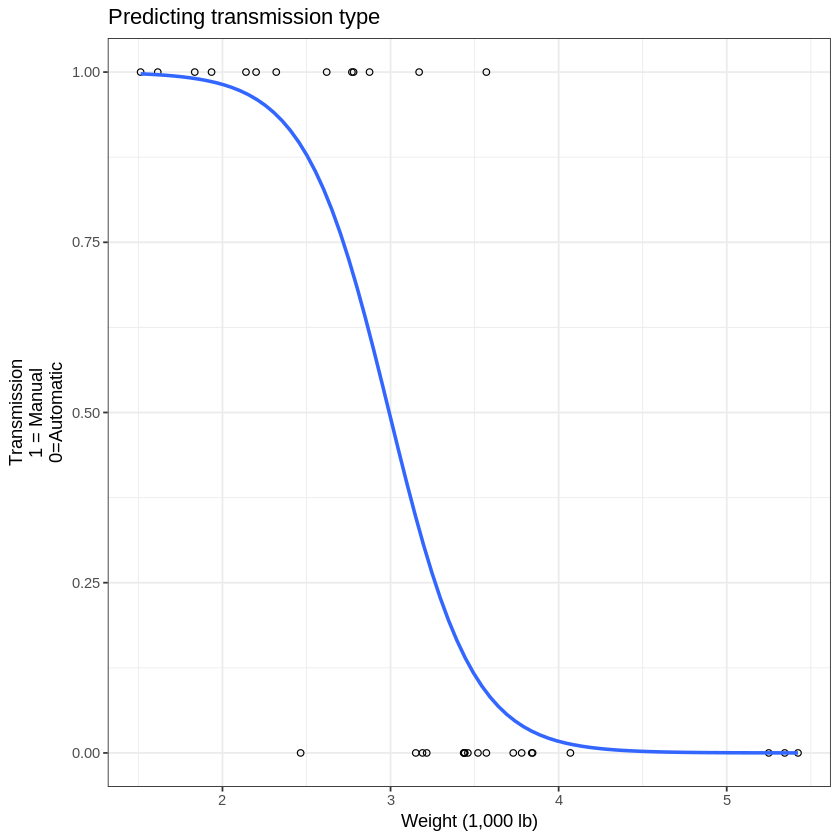

In [37]:
## Show the relationship between car weight and transmission type
NewCar %>%
  ggplot(aes(x = wt,
             y = am)) +
  geom_point(shape = 1) + ## Scatterplot geometric object
  geom_smooth(method      = "glm", se = FALSE,
              formula     = y ~ x,
              method.args = list(family = binomial)) +
  labs(x     = "Weight (1,000 lb)",
       y     = "Transmission\n1 = Manual\n0=Automatic",
       title = "Predicting transmission type") +
  theme_bw()

**Predicting transmission type from the miles-per-gallon**

Here we have a more shallow, positive trend. As the MPG variable increases, the more likely that a car has a manual (`am` = 1) transmission. Automatic transmission cars (`am` = 0) tend to have less mpg.

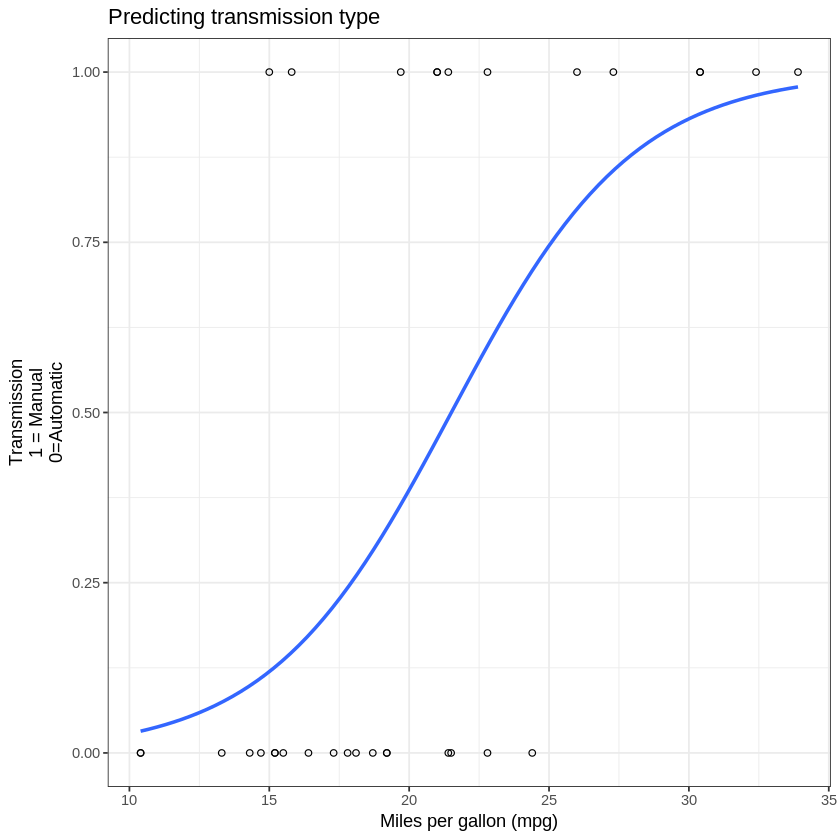

In [82]:
## Show the relationship between car mpg and transmission type
mpgXmiss <-
  NewCar %>%
  ggplot(aes(x = mpg,
             y = am)) +
  geom_point(shape = 1) + ## Scatterplot geometric object
  geom_smooth(method      = "glm",
              se          = FALSE,
              formula     = y ~ x,
              method.args = list(family = binomial)) +
  labs(x     = "Miles per gallon (mpg)",
       y     = "Transmission\n1 = Manual\n0=Automatic",
       title = "Predicting transmission type") +
  theme_bw()

## Show the MPG and transmission plot
mpgXmiss

# Logistic regression

To conduct logistic regression, we will apply the log-odds link function (i.e., logistic/logit function) via the generalized linear model. To do so, we can set the family argument to binomial.

There are other types of link functions for binomial data (e.g., probit, complementary log-log). The default in the binomial family is a logit link function but we can expressly ensure this is the case.

Two models:
- $logit(Pr(y = 1)) = b_0 + b_1 \cdot wt$

- $logit(Pr(y = 1)) = b_0 + b_1 \cdot mpg$

**Note**: To the right of the equation, our regression model is doing the same thing as before. We are trying to combine (weighted) variables to find our line-of-best-fit. The difference with traditional (i.e., ordinary least squares) regression is that we are transforming the outcome variable, the part of the equation to the left of the equal sign.

In [39]:
## Logistic regression predicting transmission from car weight
WtMod <- glm(am ~ wt, family = binomial(link = "logit"), data = NewCar)

## Logistic regression predicting transmission from car mpg
MpgMod <- glm(am ~ mpg, family = binomial(link = "logit"), data = NewCar)

## Interpreting the output: Weight

The estimated model terms (i.e., intercept and slope) are in their linear form and the outcome variable is in the log-odds of the probability units.

**Raw interpretation:**

- Intercept ($b_0$): When wt is zero, the log-odds of the probability of a manual transmission is 12.04. Although weight cannot be zero, if it were, the probability of being manual is virtually 1.

- Slope ($b_1$): For every 1-unit increase in weight, the log-odds of the probability of a manual transmission decreases by 4.02 log-odds units.

**Exponentiated interpretation:**
- Intercept ($e^{b_0}$): When wt is zero, the odds of a manual transmission is 169,000 to 1. Again, this is virtually guaranteed to be a manual car.

- Slope ($e^{b_1}$): For every 1-unit increase in weight, the odds of a manual transmission is 0.02-fold, representing a sharp decrease in the probability as weight increases. Remember, multiplying by 0.02 results in a large decrease.

In [40]:
## Show the parameters from the am ~ wt model
WtMod %>%
  parameters()

Parameter,Coefficient,SE,CI,CI_low,CI_high,z,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),12.04037,4.509706,0.95,5.213795,23.628911,2.669879,Inf,0.007587858
wt,-4.02397,1.436416,0.95,-7.698930,-1.833365,-2.801396,Inf,0.005088198


In [17]:
## Show the parameters from the am ~ wt model
WtMod %>%
  parameters(exponentiate = TRUE)

Parameter,Coefficient,SE,CI,CI_low,CI_high,z,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.694596e+05,7.642129e+05,0.95,1.837902e+02,1.827703e+10,2.669879,Inf,0.007587858
wt,1.788183e-02,2.568575e-02,0.95,4.533119e-04,1.598747e-01,-2.801396,Inf,0.005088198


The output above is hard to interpret because of the decimal places. The intercept is very large ($1.69 \times 10^5$) compared to the weight variable ($1.79 \times 10^{-2}$). We can use a line of code to round all values in the table except for the 'Parameter' column (this is a character string, we cannot round words): `mutate(across(-Parameter, ~ round(.x, 5)))`.

The `mutate()` function will change/transform/alter our data, the `across()` function is doing the same change across all columns, the `-Parameter` code is basically saying to change all columns *except* for the Parameter column (because we cannot round character vectors), and the `round()` function is rounding all those columns (except Parameter) to 2 digits.  

In [41]:
## Show the parameters from the am ~ wt model
WtMod %>%
  parameters(exponentiate = TRUE) %>%
  mutate(across(-Parameter, ~ round(.x, 2))) ## Round table output to 2 digits

Parameter,Coefficient,SE,CI,CI_low,CI_high,z,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),169459.57,764212.86,0.95,183.79,1.827703e+10,2.67,Inf,0.01
wt,0.02,0.03,0.95,0.00,1.600000e-01,-2.80,Inf,0.01


## Visualizing linear vs logit prediction: Weight

We already have the logistic curves plotted above. We can show that our logistic regression prediction is the same principle of multiple regression. Specifically, if we logit transform our outcome variable, we have a perfectly linear prediction again.

**Note**: I am first creating the logit-transformed version of our predicted outcome scores for plotting.

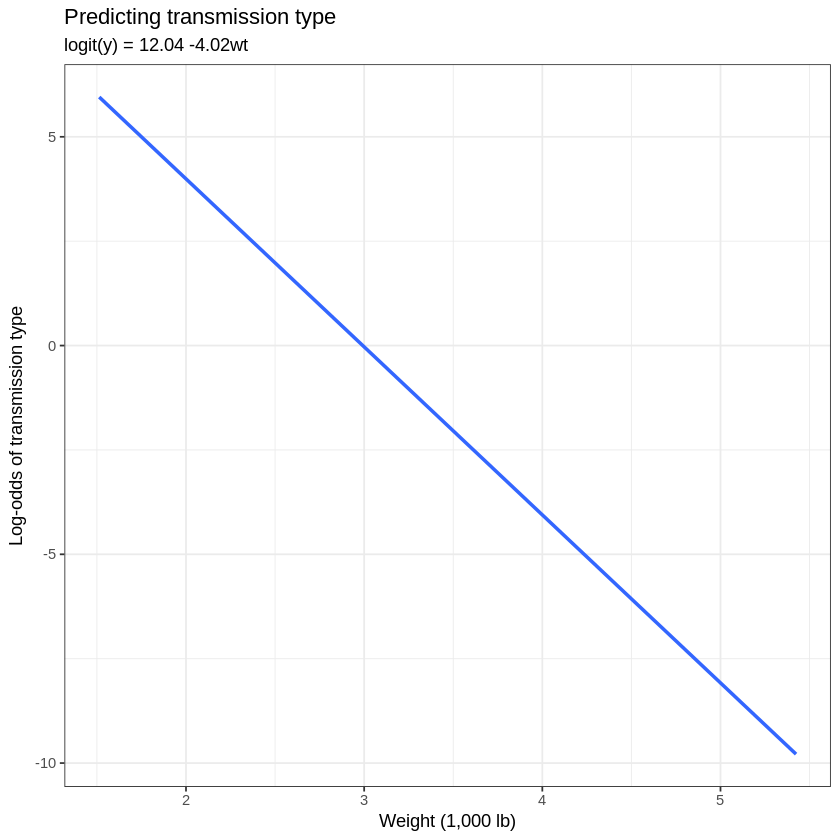

In [42]:
## Add fitted and fitted logit values to dataset
LogitCars <-
  NewCar %>%
  mutate(fittedWt  = WtMod$fitted.values,
         logitWt   = log(fittedWt / (1 - fittedWt)), ## Logistic function
         fittedMpg = MpgMod$fitted.values,
         logitMpg  = log(fittedMpg / (1 - fittedMpg))) ## Logistic function

## Plot results on the logit scale
#LogitWtVis <-
  LogitCars %>%
  ggplot(aes(y = logitWt, x = wt)) +
  geom_smooth(method = "glm", se = FALSE, formula = y ~ x) +
  labs(y = "Log-odds of transmission type",
       x = "Weight (1,000 lb)",
       title = "Predicting transmission type",
       subtitle = "logit(y) = 12.04 -4.02wt") +
  theme_bw()

## Interpreting the output: MPG

The estimated model terms (i.e., intercept and slope) are in their linear form and the outcome variable is in the log-odds of the probability units.

**Raw interpretation:**
- Intercept ($b^0$): When mpg is zero, the log-odds of the probability of a manual transmission is -6.60. Although mpg cannot be zero, if it were, the probability of being manual is virtually 0.

- Slope ($b^1$): For every 1-unit increase in weight, the log-odds of the probability of a manual transmission increases by 1.36 log-odds units.

**Exponentiated interpretation:**
- Intercept ($e^{b_0}$): When mpg is zero, the odds of a manual transmission is 0.001360 to 1. Again, this is virtually guaranteed to be a manual car.

- Slope ($e^{b_1}$): For every 1-unit increase in mpg, the odds of a manual transmission is 1.36-fold, representing a decent increase in the probability as mpg increases. Remember, multiplying by 1.36 is an increase in the probability.

In [43]:
## Show the parameters from the am ~ mpg model
MpgMod %>%
  parameters()

Parameter,Coefficient,SE,CI,CI_low,CI_high,z,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-6.6035267,2.3514416,0.95,-12.3281402,-2.7717638,-2.808289,Inf,0.004980557
mpg,0.3070282,0.1148416,0.95,0.1220088,0.5874914,2.673493,Inf,0.007506579


In [44]:
## Show the parameters from the am ~ mpg model
MpgMod %>%
  parameters(exponentiate = TRUE) %>%
  mutate(across(-Parameter, ~ round(.x, 4))) ## Round table output to 4 digits

Parameter,Coefficient,SE,CI,CI_low,CI_high,z,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.0014,0.0032,0.95,0.0000,0.0626,-2.8083,Inf,0.0050
mpg,1.3594,0.1561,0.95,1.1298,1.7995,2.6735,Inf,0.0075


## Visualizing linear vs logit prediction: MPG

We shall do the same to plot the logit version of our data using milse per gallon as our predictor.

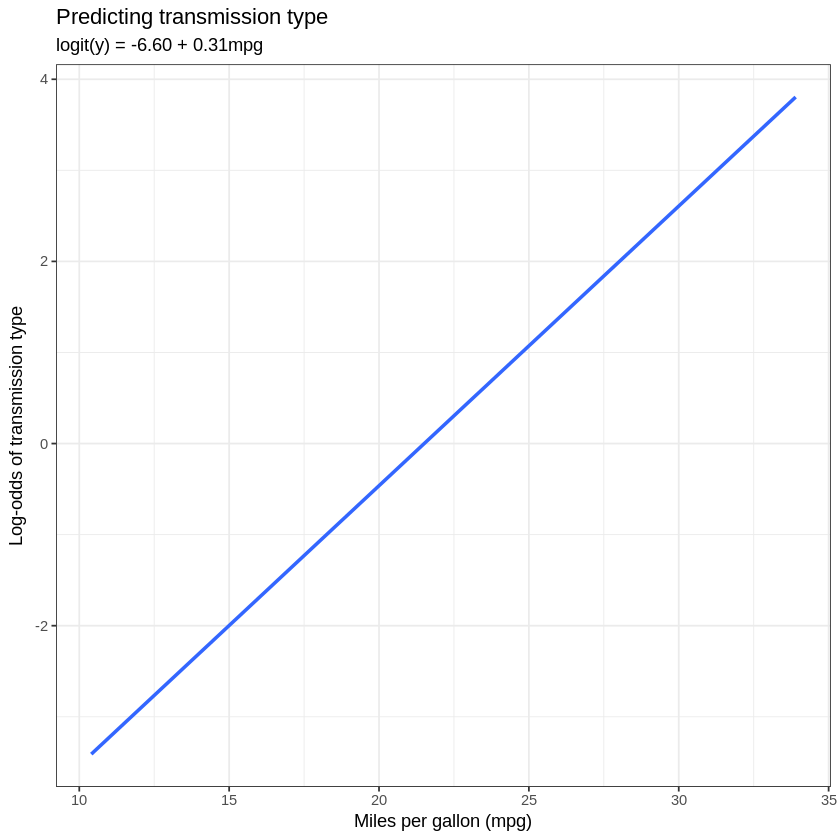

In [45]:
## Plot results on the logit scale
LogitCars %>%
  ggplot(aes(y = logitMpg,
             x = mpg)) +
  geom_smooth(method  = "glm",
              se      = FALSE,
              formula = y ~ x) +
  labs(y        = "Log-odds of transmission type",
       x        = "Miles per gallon (mpg)",
       title    = "Predicting transmission type",
       subtitle = "logit(y) = -6.60 + 0.31mpg") +
  theme_bw()

# Model fit

To determine model fit, we can compute Tjur’s pseudo-R2 as follows:

1) Average predicted probability when observed y = 1

2) Average predicted probability when observed y = 0

3) Absolute value of #1 minus #2 above: |#1 − #2|

The interpretation of this statistic is a little difficult. It is essentially the model’s ability to correctly classify
points.


## The 'by hand' approach

The `estimate_expectation()` function is using our model to produce the estimated outcome values (i.e., the $\hat{y}$ values).

Steps 1 and 2 is to calculate the average of the predicted probabilities--remember that our `Predicted` variable vector above is a predicted probability. First we calculate the average predicted probability when transmission is manual (i.e., `am` = 1). Second we calculate the average predicted probability when transmission is automatic (i.e., `am` = 0).

The second step is to take the absolute value of their difference. If our model has *perfect* prediction, the average probabilities will be 1 - 0. If we have equal probabilities in both cases (e.g., .50 - .50), our $R^2_{Tjur}$ value will be near zero.

In [56]:
## Determine the predicted probabilities given the glm
## Dataset with IV, DV, and predicted DV scores
Predicted  <-
  estimate_prediction(WtMod) %>%
  mutate(am = NewCar$am)

## Show the first few rows of the predicted probabilities
Predicted %>%
  head(n = 10)

,wt,Predicted,CI_low,CI_high,Residuals,am
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,2.620,0.81721153,2.220446e-16,1,0.18278847,1
Mazda RX4 Wag,2.875,0.61572833,2.220446e-16,1,0.38427167,1
Datsun 710,2.320,0.93730690,2.220446e-16,1,0.06269310,1
Hornet 4 Drive,3.215,0.28973042,2.220446e-16,1,-0.28973042,0
Hornet Sportabout,3.440,0.14159721,2.220446e-16,1,-0.14159721,0
Valiant,3.460,0.13209438,2.220446e-16,1,-0.13209438,0
Duster 360,3.570,0.08905706,2.220446e-16,1,-0.08905706,0
Merc 240D,3.190,0.31086157,2.220446e-16,1,-0.31086157,0
Merc 230,3.150,0.34634696,2.220446e-16,1,-0.34634696,0


In [69]:
## Dataset with IV, DV, and predicted DV scores
Predicted  <-
  estimate_prediction(WtMod) %>%
  mutate(am = NewCar$am)

## Average predicted prob when am == 1
WtProb1 <-
  Predicted %>%
  filter(am == 1) %>%
  summarize(MeanProb1 = mean(Predicted))

## Average predicted prob when am == 0
WtProb0 <-
  Predicted %>%
  filter(am == 0) %>%
  summarize(MeanProb0 = mean(Predicted))

## Compute Tjur's pseudo R2
ByHand <-
  abs(WtProb1 - WtProb0) %>%
  as.numeric() ## Force the output to be a single value (i.e., a scalar)

## Print value
round(ByHand, 3)

[1] 0.624

Alternatively, we can use the convenient `r2_tjur()` function from the easystats package. We can compare the output to check our 'by hand' math. Phew, the math appears to check out, both values are exactly equal (to like 17 decimal places).

In [68]:
## Use the easystats package to do this for us (phew)
Function <-
  r2_tjur(WtMod) %>%
  as.numeric() ## Force the output to be a single value (i.e., a scalar)

## Print the output
round(Function, 3)

## Compare values
all.equal(Function, ByHand)

[1] 0.624

[1] TRUE

# Model-based predictions

It is difficult to interpret logistical regression parameters because log-odds and odds ratios are not terribly intuitive.

However, given (a) a logistic regression model and (b) specified values of the IVs, we can determine the predicted probability that y = 1 (i.e., probability of manual transmission).

Below, I create a simple data.frame (a dataset) where we have one column: `wt`. This column takes on values from a sequences (i.e., `seq()`) starting from 1.5 and going to 5.5 using 0.5 step increments. Given these specific values, we can find the predicted probability based on our model.

In [72]:
## Some weight values to estimate the predicted probability of transmission type
WtData2Predict <-
  data.frame("wt" = seq(from = 1.5,
                        to = 5.5,
                        by = 0.5))

## Show the generated data
WtData2Predict

wt
<dbl>
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5


In [73]:
## Determine predicted probabilities given (a) the model and (b) specified values
estimate_expectation(model = WtMod,
                     data  = WtData2Predict) %>%
  round(4) ## Round output to 4 digits

,wt,Predicted,SE,CI_low,CI_high
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.5,0.9975,0.0059,0.7894,1.0000
2,2.0,0.9819,0.0303,0.6585,0.9993
3,2.5,0.8787,0.1126,0.4775,0.9829
4,3.0,0.4921,0.1513,0.2283,0.7604
5,3.5,0.1147,0.0818,0.0260,0.3858
6,4.0,0.0170,0.0235,0.0011,0.2125
7,4.5,0.0023,0.0048,0.0000,0.1193
8,5.0,0.0003,0.0009,0.0000,0.0662
9,5.5,0.0000,0.0001,0.0000,0.0364


These are our predictions. If somebody gives us a car and the only information we know its weight is 2.0 (here, that's 2,000 pounds), we are about 98% sure that car is a manual transmission car (given our model and the data it was trained on).

Same with a weight of 4.0 (4,000 pounds), we are 1.7% sure that car will be manual transmission.

# Seeing odds ratio via model prediction

The probabilities increase in a non-linear fashion (i.e., the non-transformed data has an S-shaped curve) but the *odds ratio* of the probabilities *are* linear and constant.

That sounds confusing, I'm sure. Notice the S-shaped curve, the slope of this curve is not the same at every value of the `mpg` variable. However, the odds ratio is always going to be constant so we can use that odds ratio as a metaphor for a slope. A slope tells us the rate of change in 1 variable as we change the value of another. An odds ratio is sort of telling us the relationship between the variables in a binary context.

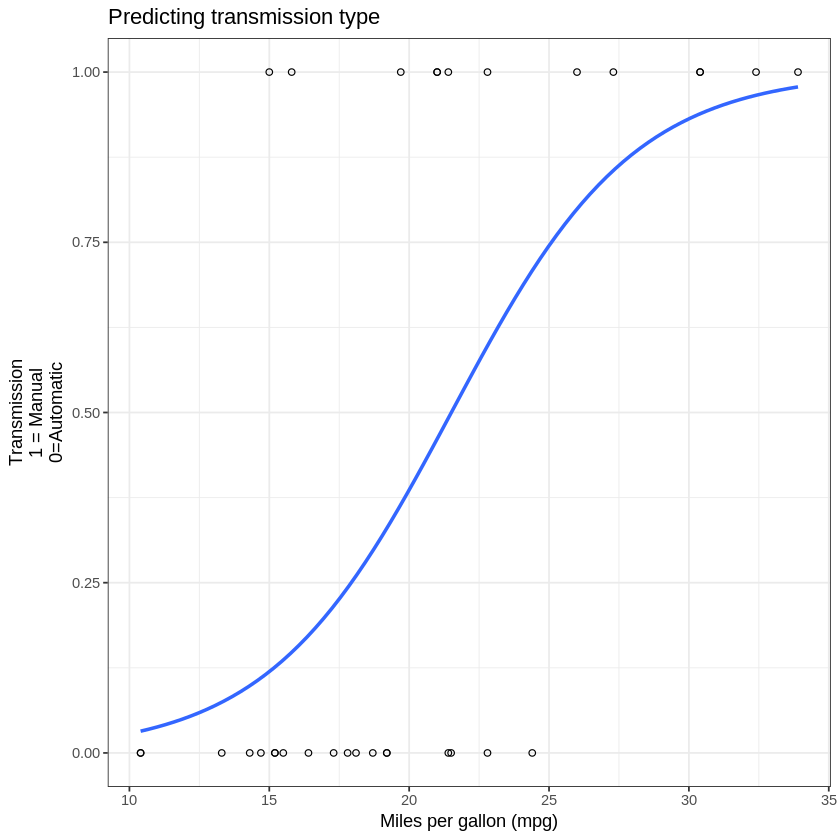

In [83]:
## Show the am ~ mpg plot again
mpgXmiss

Note: I do not expect you to memorize this section, this is illustrative to better understand these concepts.

For a 1-unit increase in mpg, the odds of manual transmission increase by 1.36-fold.

When we exponentiate the slope parameter (i.e., $e^{b_1}$), it is equivalent to the following:

$$\text{Odds ratio}: \frac{e^{b_0 + b_1 \cdot (x+1)}}{e^{b_0 + b_1 \cdot x}}.$$

This is the same as the ratio of the odds for $x + 1$ to the odds for $x$:

$$\text{Odds ratio} = \frac{\frac{Pr(y=1|x+1)}{1 - Pr(y=1|x+1)}}{\frac{Pr(y=1|x)}{1 - Pr(y=1|x)}} = \frac{\text{Odds}(x+1)}{\text{Odds}(x)}.$$

In [79]:
## Some mpg values to estimate the predicted probability of transmission type
MpgData2Predict2 <-
  data.frame("mpg" = c(20, 21, 28, 29))

## Determine predicted probabilities given (a) the model and (b) specified values
Predicted <-
  estimate_expectation(model = MpgMod,
                       data  = MpgData2Predict2)

## Predicted probabilities for 20, 21, 28, and 29 MPG, respectively
data.frame("mpg"       = MpgData2Predict2,
           "Predicted" = Predicted$Predicted)

mpg,Predicted
<dbl>,<dbl>
20,0.3862832
21,0.4610951
28,0.8800879
29,0.9089011


Recall that an odds is computed as the following: $\text{odds} = \frac{p}{1 - p}.$

In [80]:
## The odds given MPG equals 20 and 21
Odds20 <- 0.3862832 / (1 - 0.3862832)
Odds21 <- 0.4610951 / (1 - 0.4610951)

## Odds ratio
(Odds21 / Odds20) %>% round(2)

[1] 1.36

In [81]:
## The odds given MPG equals 28 and 29
Odds28 <- 0.88008788 / (1 - 0.88008788)
Odds29 <- 0.90890112 / (1 - 0.90890112)

## Odds ratio
(Odds29 / Odds28) %>% round(2)

[1] 1.36

The slope of the S-shaped curve in the previous graph was not constant. However, the odds-ratio comparing mpg = 20 to mpg = 21 (i.e., 1.36) is the exact same as the odds-ratio comparing mpg = 28 to mpg = 29 (i.e., 1.36). The odds-ratio is constant as we compare `mpg` values.